In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize_scalar

from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import cm
#import colormaps
#col = [ colormaps.viridis(x) for x in np.linspace(0, 1, 20) ]

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize']=14
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['legend.fancybox'] = True
plt.rcParams['legend.frameon'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['lines.linewidth'] = 1.
#from matplotlib import rc
#rc('text', usetex=True)

from scipy.optimize import minimize_scalar

In [2]:
def EnergyRVS(a, size=10.,  x_min=1., x_max=1.e3):
    """Energy Random Variates. Produces a value for energy.
    The energy values are distributing randomly according to 
    a power law PDF.
    """
    y = np.random.uniform(0., 1., size)
    if a==1.:
        norm = np.log(x_max) - np.log(x_min)
        return np.exp(y*norm + np.log(x_min))
    else:
        norm = (x_max**(1.-a) - x_min**(1.-a))
        return(y*norm + x_min**(1.-a))**(1./(1.-a))

def EnergyPDF(x, a, x_min=1., x_max=1.e5):
    """ PDF function for energy, between x_min and x_max
    A power law, with Prob(x) = k x**(-a), for normailsation factor k
    """
    if a==1.:
        norm = np.log(x_max) - np.log(x_min)
    else:
        norm = (x_max**(1.-a) - x_min**(1.-a)) / (1.-a)
    return x**(-a) / norm

In [3]:
def LLhFunction(a, data):
    """Calculates the LLh by summing each individual LLh
    """
    return -np.sum(np.log(EnergyPDF(data, a)))

def DoTrial(n):
    """Creates a dataset with n entries.
    Minimises the LLh, and then calculates the Test Statistic of this value.
    """
    data = EnergyRVS(2., size=int(n))
    res = minimize_scalar(LLhFunction, args=data)
    TestStat = -(LLhFunction(res.x, data) - LLhFunction(2., data))
    return res.x, TestStat

In [4]:
#Array containing the number of signals (n_s)
TestNS = np.array([1., 2., 3., 4., 5., 7., 10., 20., 50., 100., 200., 500., 1000.])
NTrials = 1000

#Creates a dictionary for results
Results = dict()

#Loops over each n_s
for i in TestNS:
    #Creates a sub-dictionary for each n_s"
    Results[i] = dict()
    #Creates blank arrays (length Ntrials) to store lambda/gamma
    Results[i]['gamma'] = np.zeros(NTrials)
    Results[i]['lambda'] = np.zeros(NTrials)
    
    #Loops over Ntrials (1000)
    for j in range(NTrials):
        #For each trial, "does trial" with n_s and returns corresponding gamma/lambda
        Results[i]['gamma'][j], Results[i]['lambda'][j] = DoTrial(i)
        
#Collates results in dictionary
Evaluation = dict()
Evaluation['AverageGamma'] = np.array([np.average(Results[i]['gamma']) for i in TestNS])
Evaluation['GammaSigma'] = np.array([np.std(Results[i]['gamma']) for i in TestNS])
Evaluation['AverageLambda'] = np.array([np.median((Results[i]['lambda'])) for i in TestNS])
Evaluation['LambdaSigma'] = np.array([np.std((Results[i]['lambda'])) for i in TestNS])

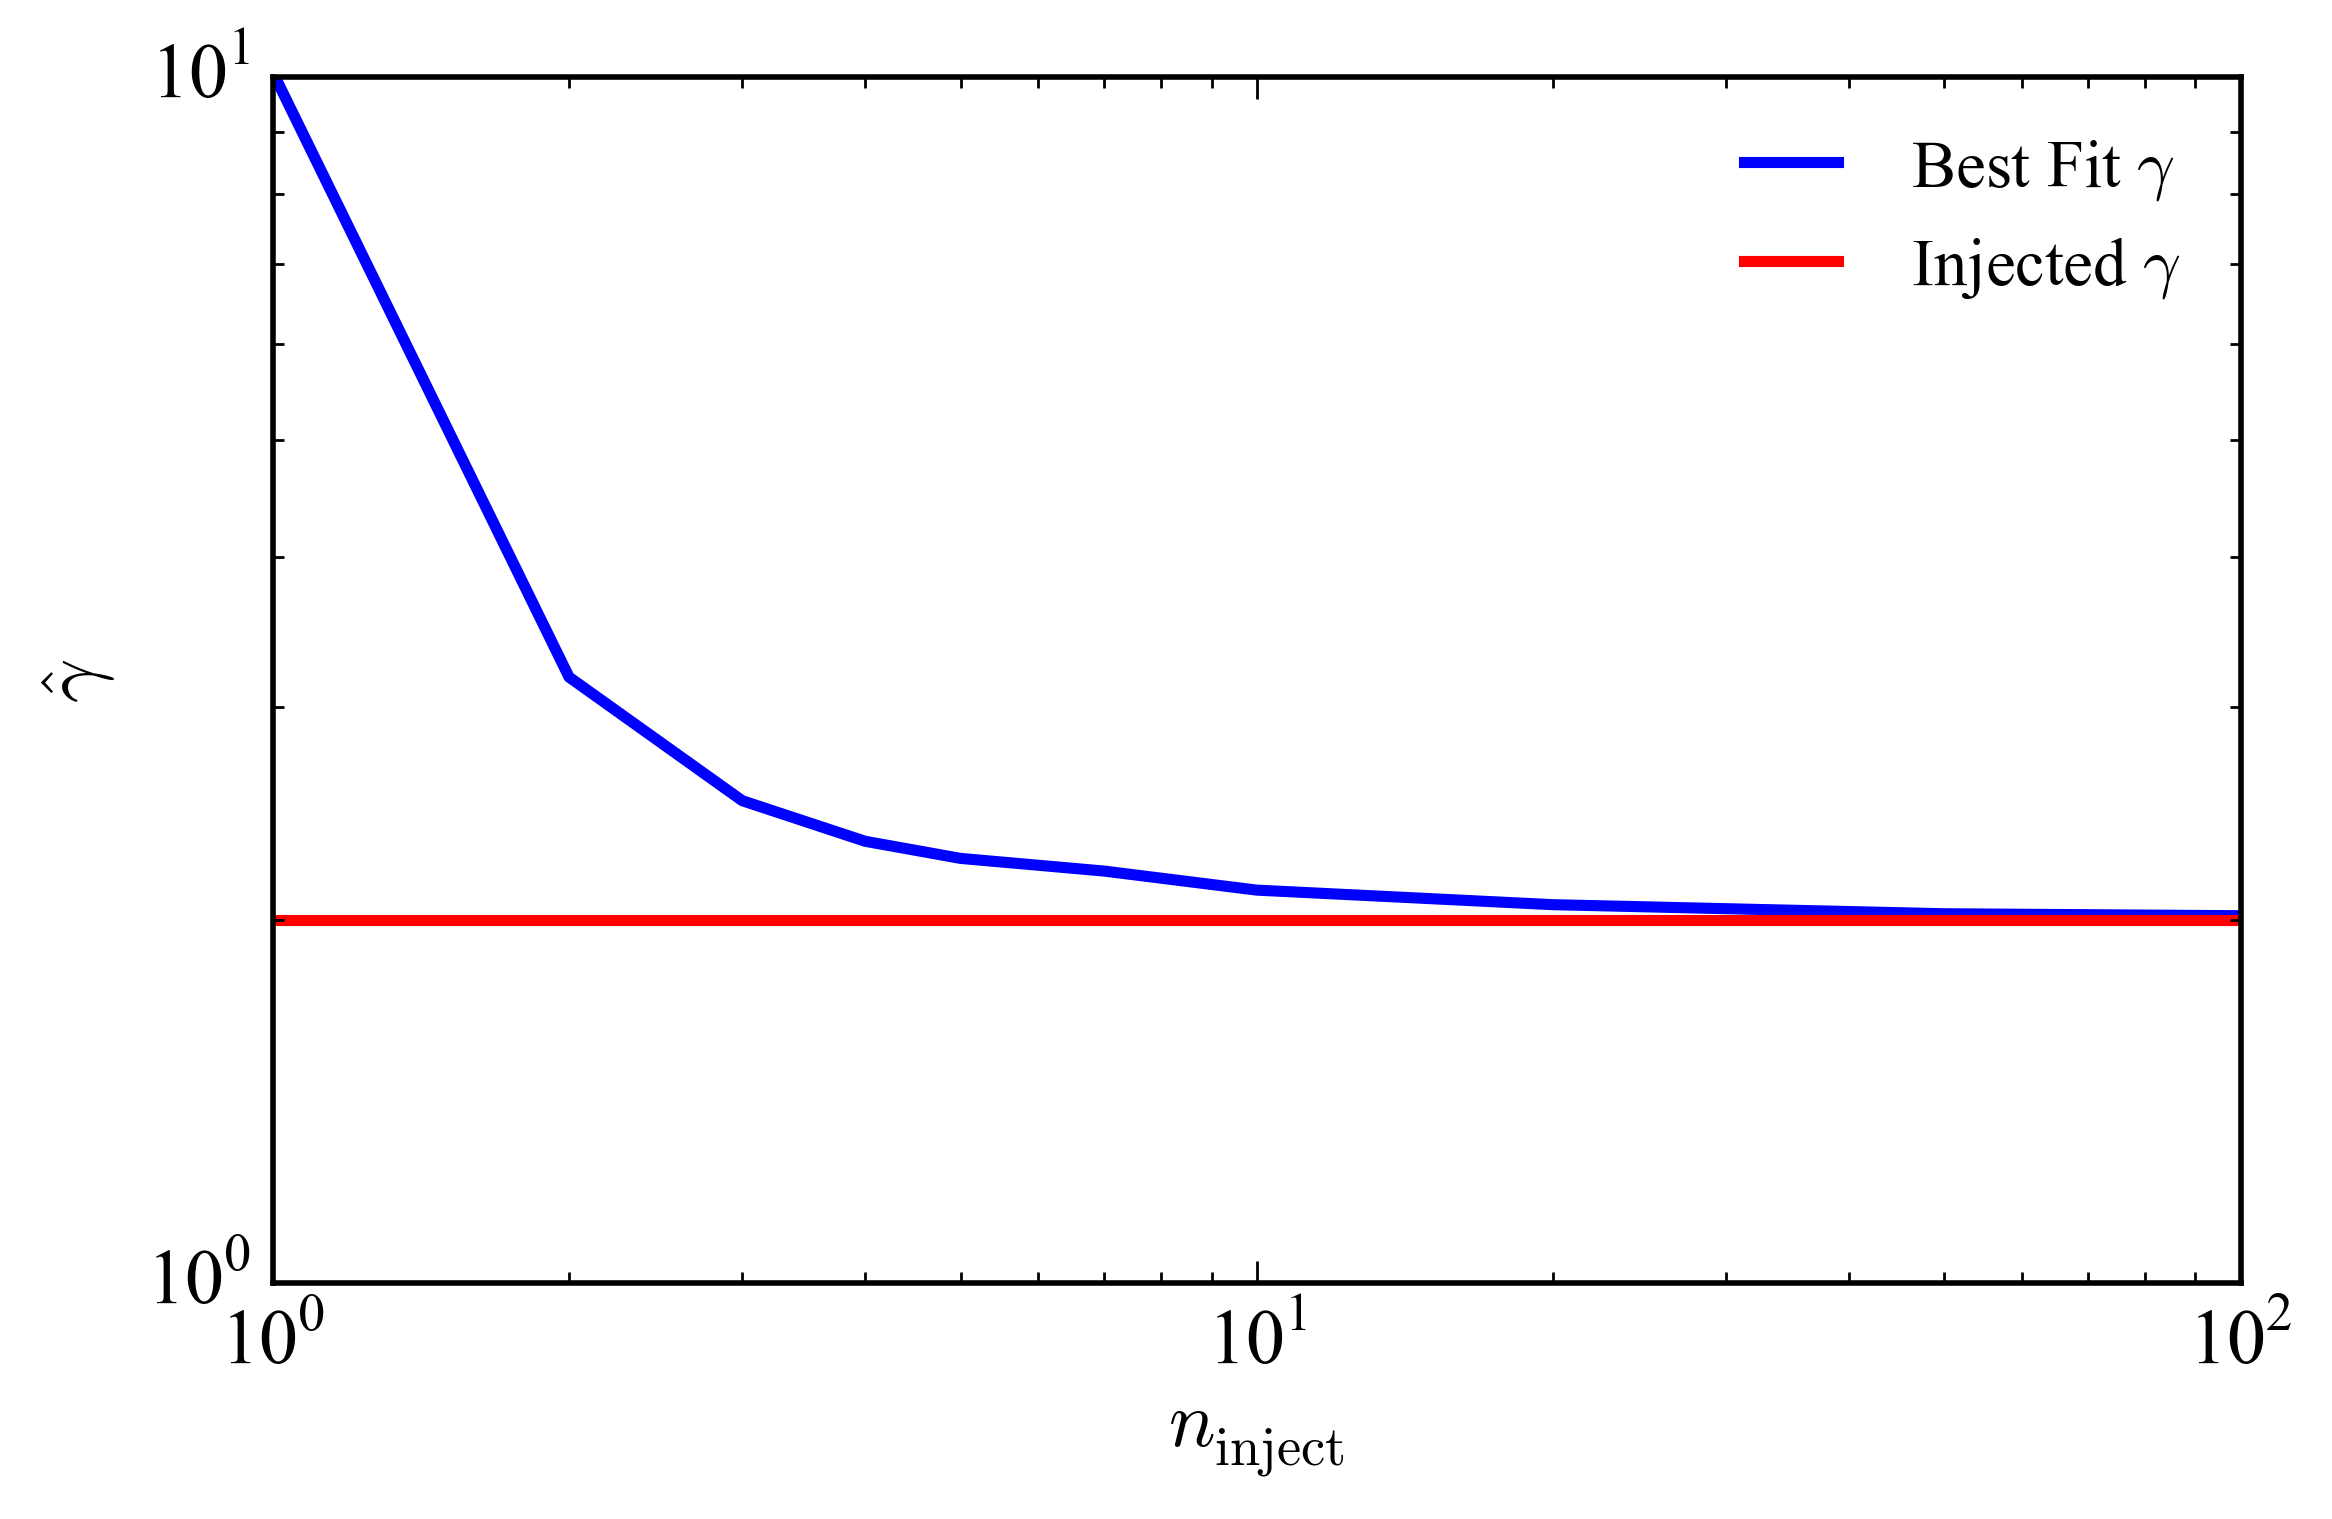

In [5]:
#Plots "average" gamma (fitted) as a function of n_s, as well as "true" gamma (2)
plt.figure()
plt.plot(TestNS, Evaluation['AverageGamma'], lw=2, label=r'Best Fit $\gamma$')
plt.xlim(1., 100.)
plt.ylim(1., 10.)
plt.semilogx()
plt.semilogy()
plt.axhline(y=2., lw=2, color='red', label=r'Injected $\gamma$')
plt.xlabel(r'$n_\mathrm{inject}$')
plt.ylabel(r'$\hat{\gamma}$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('plots/BestFitGammaDist.pdf')
plt.show()

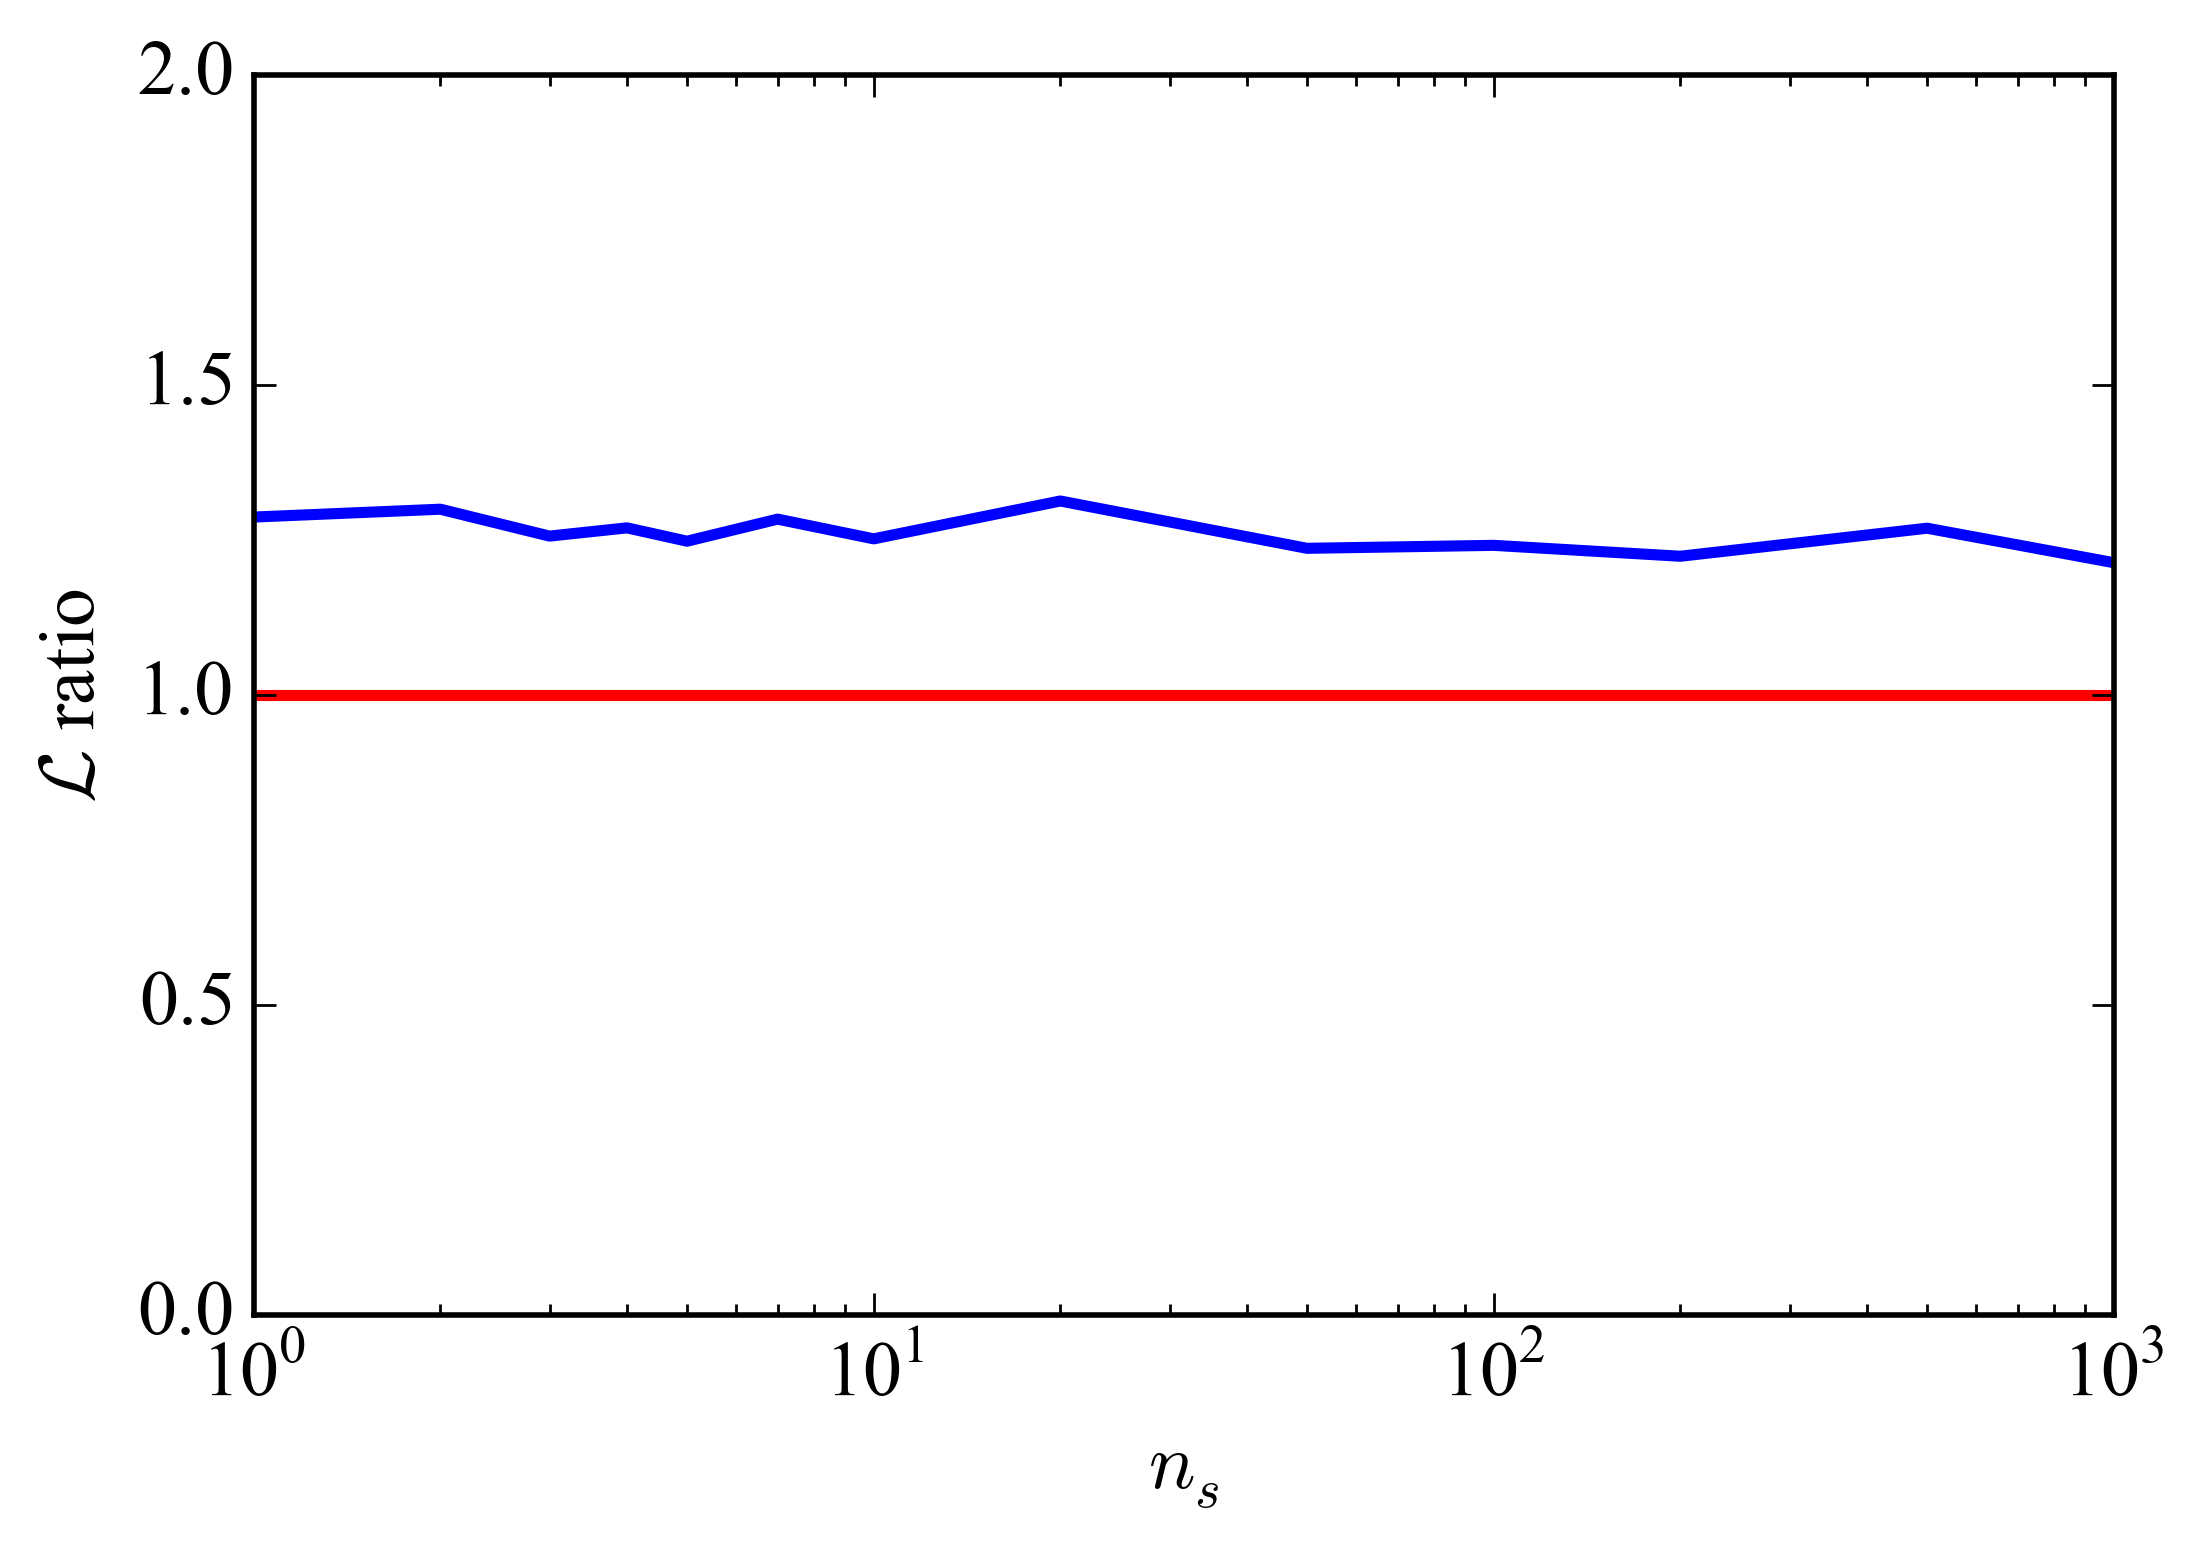

In [6]:
#Plots exp(av. lambda), i.e the reconstructed likelihood/true likelihood
plt.figure()
plt.plot(TestNS, np.exp(Evaluation['AverageLambda']), lw=2)
plt.xlim(1.e0, max(TestNS))
plt.ylim(0., 2.)
plt.semilogx()
# plt.semilogy()
plt.axhline(y=1., lw=2, color='red')
plt.xlabel(r'$n_{s}$')
plt.ylabel(r'$\mathcal{L}$ ratio')
plt.savefig('plots/test2.pdf')
plt.show()

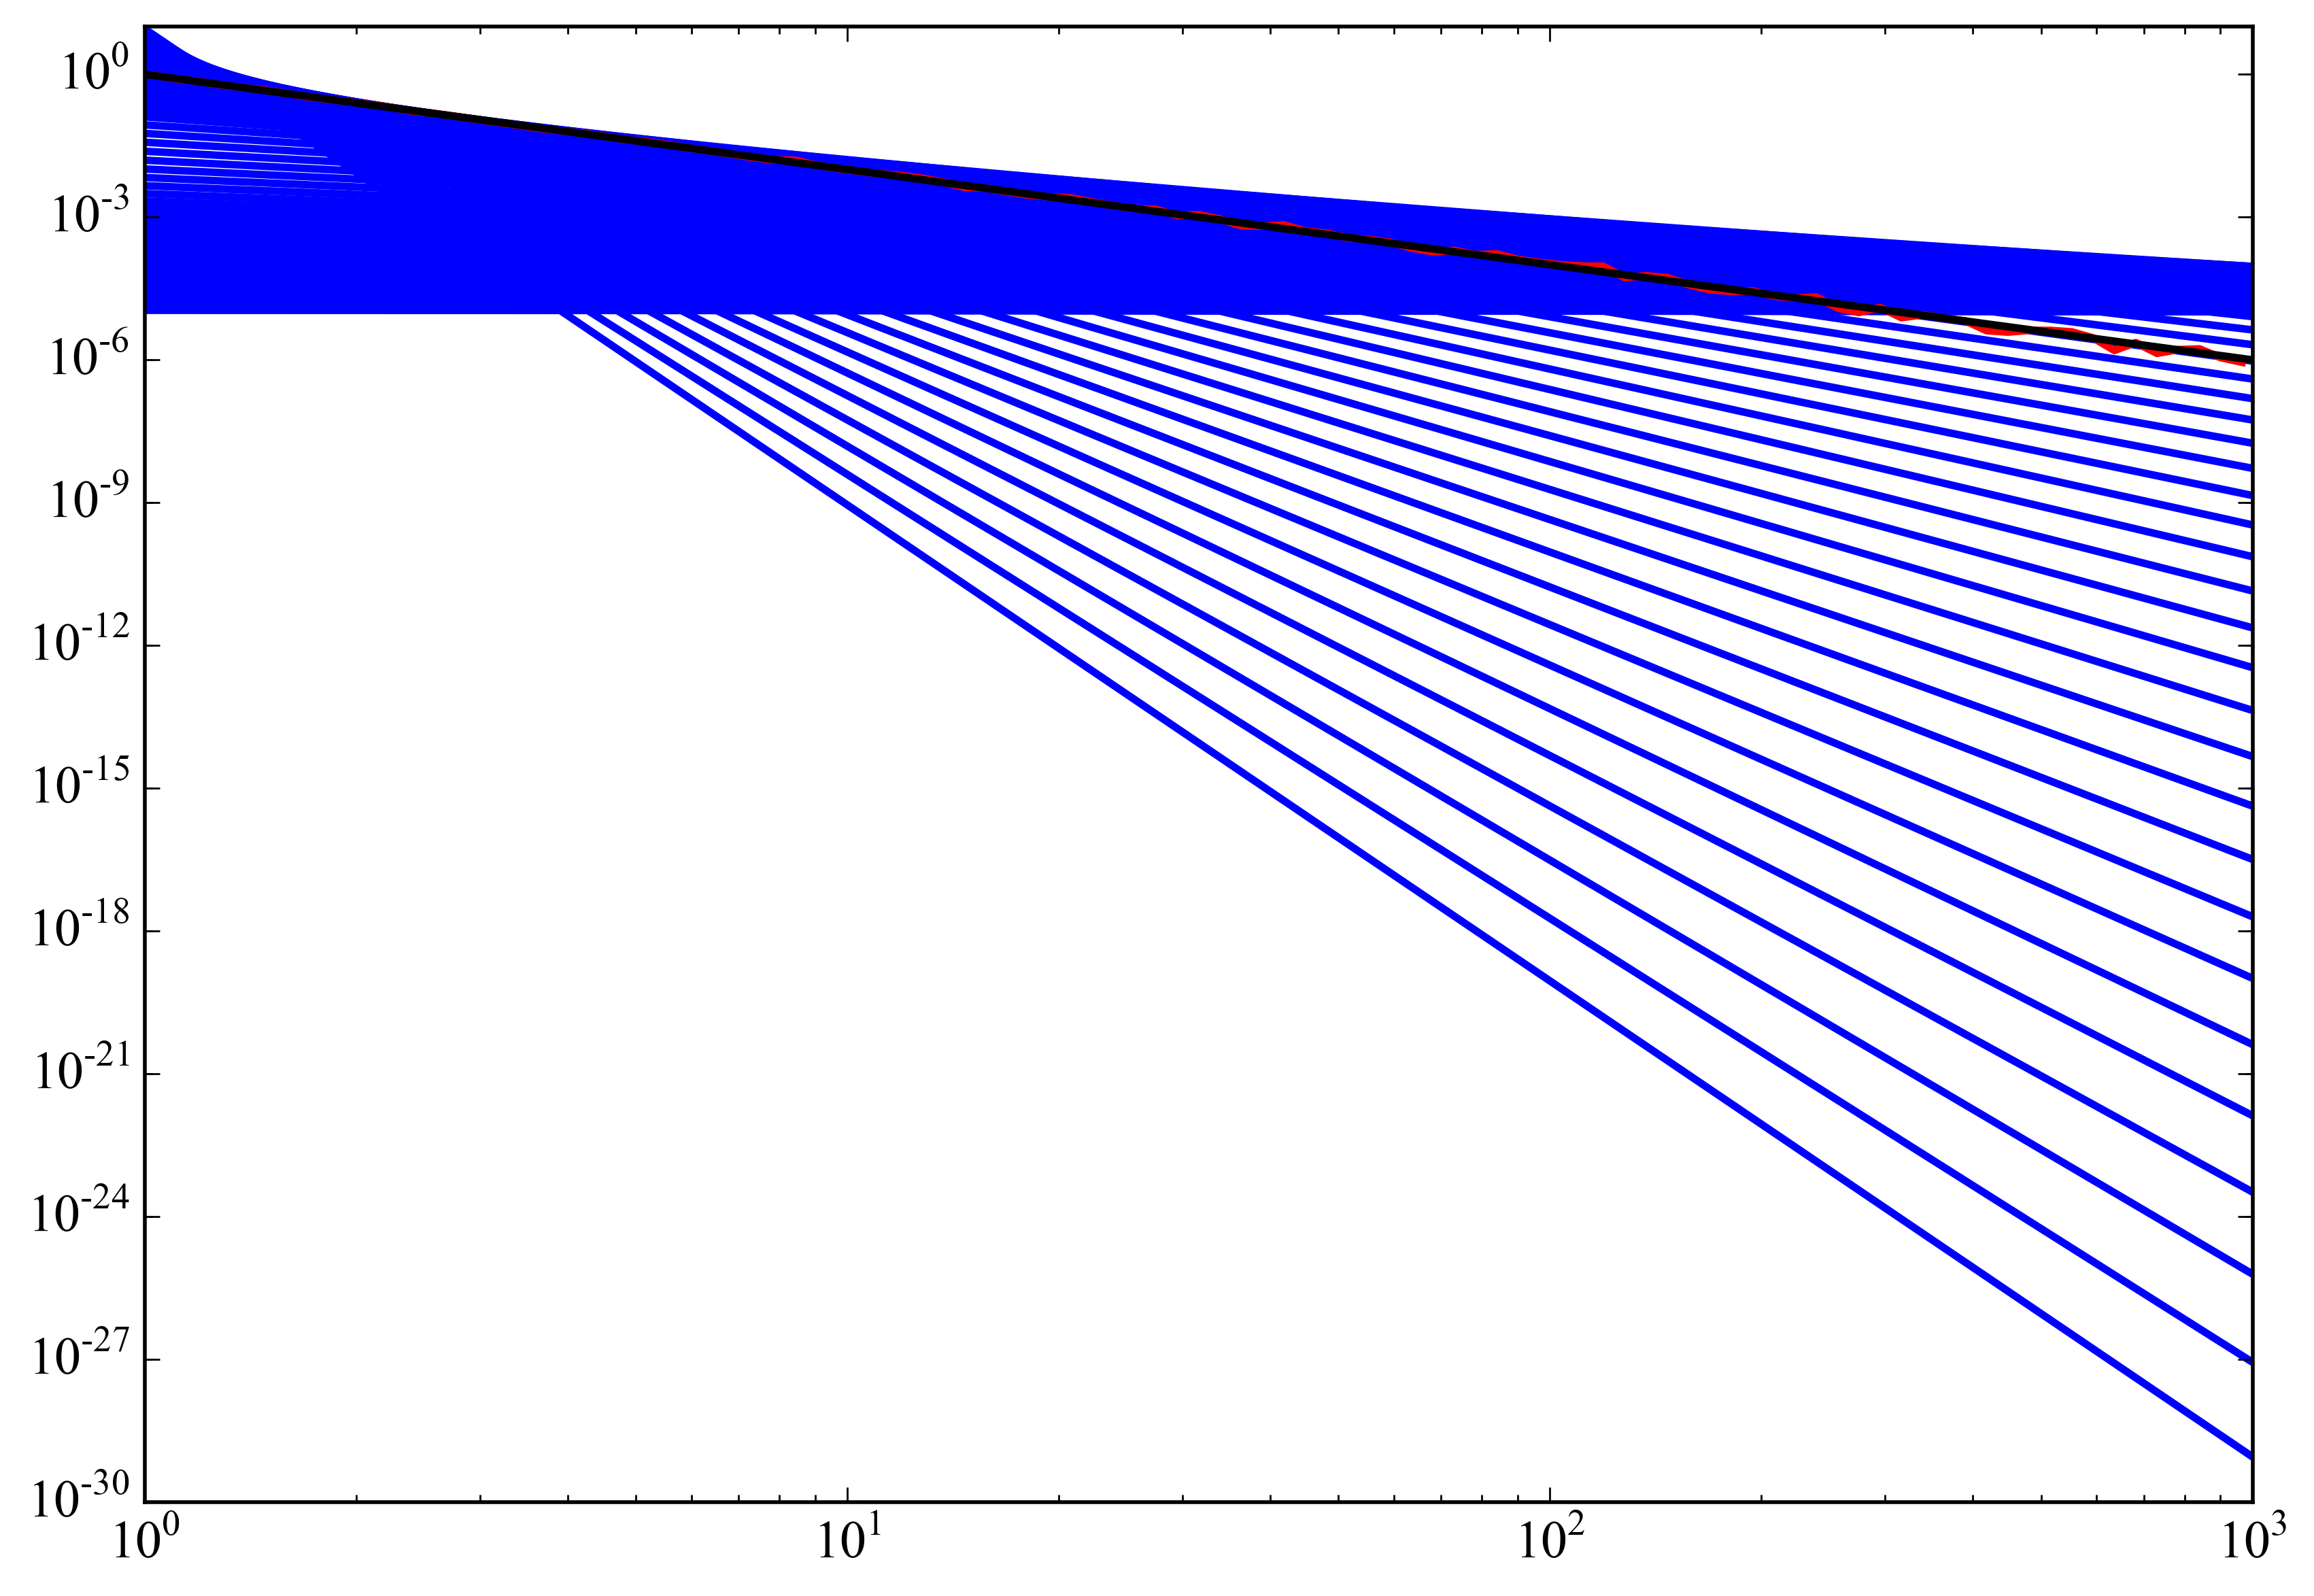

In [8]:
x = np.linspace(1., 1.e3, 1000)
y = EnergyPDF(x, 2.)

data = EnergyRVS(2., size=100000)
H = np.histogram(data, density=True, bins=np.logspace(0., 3., 100))
BinCenter = (H[1][1:]+H[1][:-1])/2.

plt.figure(figsize=(10, 7))
for gamma in np.logspace(-2., 1., 100):
    plt.plot(x, EnergyPDF(x, gamma), lw=2, color='blue')
plt.plot(BinCenter, H[0], lw=2, color='red')
plt.plot(x, y, lw=2, color='black')
plt.semilogx()
plt.semilogy()
plt.show()